### **Fontes de pesquisa:**
> **Artigos** 
- Metodologia Box-Jenkins: https://ivanildo-batista13.medium.com/metodologia-box-jenkins-ccac560e6a4f

In [1]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(365).mean() #media movel
    rolstd = timeseries.rolling(365).std() #desvio movel

    #Plot rolling statistics:
    fig = plt.subplots(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Médias Móveis')
    std = plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Teste estacionario na velocidade do vento - Macau')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Resultados do teste de Dickey-Fuller')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

def ehEstacionaria(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    
    if(dfoutput['Estatística do teste'] < dfoutput['Valor crítico (5%)'] and dfoutput['p-value'] < 0.05):
        print('É estacionária.')
    else:
        print('Não é estacionária.')

In [47]:
df_vento = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# Removendo todos as virgulas do dataset
df_vento.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_vento.Data = pd.to_datetime(df_vento.Data)

# Tranformando a coluna "Data" em index
df_vento.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_vento.select_dtypes(object).columns
df_vento[c] = df_vento[c].apply(pd.to_numeric,errors='coerce')
df_vento.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [48]:
df_pld = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv')
# Removendo todos as virgulas do dataset
df_pld.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_pld['inicio_semana'] = pd.to_datetime(df_pld['inicio_semana'])

# Tranformando a coluna "Data" em index
df_pld.set_index('inicio_semana', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_pld.select_dtypes(object).columns
df_pld[c] = df_pld[c].apply(pd.to_numeric,errors='coerce')
df_pld.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


Text(0.5, 0, 'Data')

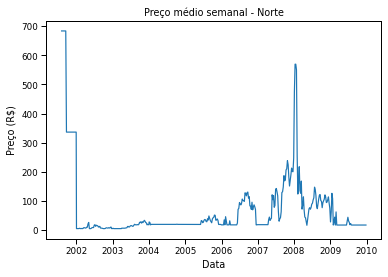

In [81]:
plt.plot(df_pld.preco_medio)
plt.title("Preço médio semanal - Norte")
plt.ylabel("Preço (R$)")
plt.xlabel("Data")

Text(0.5, 0, 'Data')

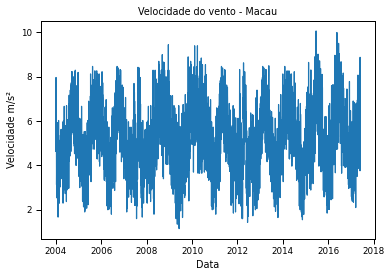

In [80]:
plt.plot(df_vento.Velocidade)
plt.title("Velocidade do vento - Macau")
plt.ylabel("Velocidade m/s²")
plt.xlabel("Data")

### Análise de séries temporais

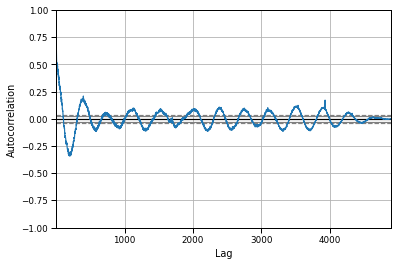

In [82]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# plot_acf(df.Velocidade,lags=40);
# plot_pacf(df.Velocidade,lags=40);
autocorrelation_plot(df_vento.Velocidade)

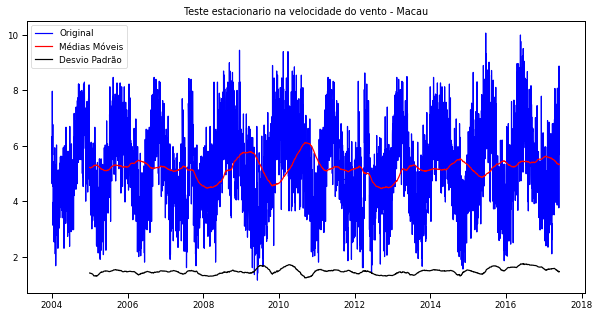

Resultados do teste de Dickey-Fuller
Estatística do teste                      -5.147908
p-value                                    0.000011
O critério de informação maximizado       30.000000
Número de observações usadas            4869.000000
Valor crítico (1%)                        -3.431694
Valor crítico (5%)                        -2.862134
Valor crítico (10%)                       -2.567086
dtype: float64


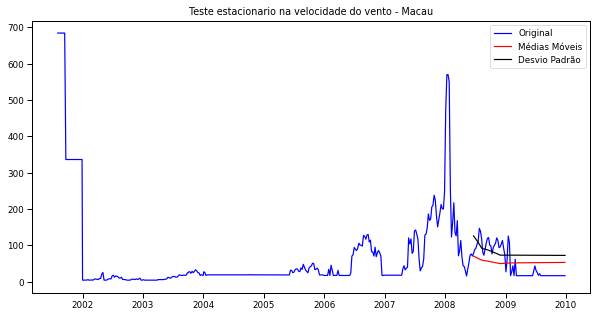

Resultados do teste de Dickey-Fuller
Estatística do teste                     -4.458580
p-value                                   0.000233
O critério de informação maximizado      16.000000
Número de observações usadas            426.000000
Valor crítico (1%)                       -3.445794
Valor crítico (5%)                       -2.868349
Valor crítico (10%)                      -2.570397
dtype: float64


In [83]:
adf_test(df_vento.Velocidade)
adf_test(df_pld.preco_medio)

NOTA: 
- De acordo com o teste de estácionáriedade, podemos perceber que o teste estatístico é maior que os três valores críticos apresentados como 1%, 5%, 10%, além disso, p-value próximo do zero, ou seja, abaixo dos 5%, podendo então rejeitar a hipótese nula de que a série não seja estácionária.

- De acordo com o teste de estacionariedade utilizando a função adfuller da biblioteca statsmodels do python, podemos perceber que o p-value está abaixo dos 5%, nesse caso, podendo então rejeitar a hipótese nula (H0) de que a série não seja estácionária (SILVA, 2020). Além disso, podemos considerar observar o teste estatístico e comparando ele com os valores críticos 1%, 5% e 10%, respectivamente, concluímos que o valor do teste está acima dos valores crítcos, sustentando então estacionariedade da série. 


## Criando o modelo

Auto ARIMA: (9,0,7)
- Autorregressão: 9
- Diferenciação: 0
- Médias móveis: 7

Conforme podemos observar, tanto o teste estatístico, quanto o algoritmo que define a ordem do modelo que vamos utilizar, informam que não há necessidade de atribuir diferenciações na série observada, nesse caso, não é necessário a série possar por transformações, visto que ela ja é estacionária

> Separação treino e teste

Etapa do pré-processamento dos dados que consiste em sepearar a base de dados em duas em treinamenento e teste, sendo possível treinar o modelo definido com a base de treino e validar os resultados obtidos com a base de teste

> Previsão de 1 passo a frente - **FORECAST**

> Previsão de VARIOS passos a frente - **ALGORITMO**

Algoritmo de treinamento e validação que consiste em treinar o modelo com a base de treino e validar o resultado obtido fora da amostra com o primeiro valor da base de teste, com isso, o valor real da base de teste é adicionado a base de treino e o processo é repetido pela quantida de passos que foi especificado no algoritmo

OBS:
- Se for utilizado um modelo de ordem (1,0,0), ou seja, apenas autorregressão, a previsão não ocorre fora da amostra e sim dentro, nesse caso, o "arimaResults" deveria devolver um valor próximo ao primeiro valor da base de teste, pensando em 1 passo a frente, porem ele devolve um valor que se aproxima do ultimo valor da base de treino.
- Se esse processo utilizando um modelo de ordem (1,0,0) for utilizado no algoritmo de treinamento e validação, o resultado será sempre um atraso do valor real em relação ao previsto, com isso, a visualização do comparativo mostra que o resultado do valor predito acompanha o valor real com um pequeno atraso, porém as métricas de erro devolve um valor muito alto.
-  Utilizando um modelo de ordem (9,0,7), este recomendado pelo algoritmo responsável por automatizar o ajuste dos parametros do modelo, e fazendo uso do mesmo algoritmo de treinamento e validação, podemos perceber que a visualização do comparativo dos valores preditos, tem um pouco de dificuldade de acompanhar as curvas de crescimento e descrecimento dos valores reais, contanto, as métricas de erro devolve um resultado melhor em relação ao modelo de ordem (1,0,0).